In [1]:
import pandas as pd

data = pd.read_hdf('./data/full_data.hd5')

In [2]:
import numpy as np

cols = ['cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_pt', 'cleanedJet_btagDeepB']
jet_data = data.loc[:, cols]
jet_data_arr = np.zeros((len(jet_data), 14, 4))
for i in range(14):
        for j, k in enumerate(cols):
            jet_data_arr[:, i, j] = jet_data.loc[:, k].map(lambda x: x[i] if len(x) > i else 0)
jet_data_arr


array([[[-5.13671875e-01,  1.56250000e+00,  1.19414330e+02,
          9.78027344e-01],
        [-1.28125000e+00, -8.07617188e-01,  9.70109711e+01,
          3.34228516e-01],
        [ 2.68798828e-01, -9.53369141e-02,  7.57926788e+01,
          2.45819092e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[-4.22851562e-01, -2.24023438e+00,  2.24808548e+02,
          1.05361938e-02],
        [ 4.18457031e-01,  8.46679688e-01,  1.24097435e+02,
          2.83813477e-02],
        [ 1.92578125e+00, -1.40234375e+00,  9.66871109e+01,
          3.70117188e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.000

In [3]:
labels = data['ttH125'].values

In [4]:
import matplotlib.pyplot as plt

# for i in range(14):
#     for j, k in enumerate(cols):
#         hist, bins, patches = plt.hist(jet_data_arr[:, i, j][(labels==1) & (jet_data_arr[:, i, j] != 0)], density=True, label=f"jet_{j+1} {k} sg", histtype='step', log=j==2)
#         plt.hist(jet_data_arr[:, i, j][(labels==0) & (jet_data_arr[:, i, j] != 0) ], density=True, label=f"jet_{j+1} {k} bg", histtype='step', bins=bins, log=j==2)
#         plt.legend()
#         plt.show()

In [45]:
# Eta-phi plane with resolution of 0.17 (stolen from VBF paper)



grid_sg, grid_bg = np.zeros((59, 45)), np.zeros((59, 45))

for i in range(14):
    sg_etas = get_index(jet_data_arr[:,i,0][(labels==1) & (jet_data_arr[:, i, 2] != 0)], cat='eta')
    bg_etas = get_index(jet_data_arr[:,i,0][(labels==0) & (jet_data_arr[:, i, 2] != 0)], cat='eta')
    sg_phis = get_index(jet_data_arr[:,i,1][(labels==1) & (jet_data_arr[:, i, 2] != 0)], cat='phi')
    bg_phis = get_index(jet_data_arr[:,i,1][(labels==0) & (jet_data_arr[:, i, 2] != 0)], cat='phi')
    sg_pt = jet_data_arr[:, i, 2][(labels==1) & (jet_data_arr[:, i, 2] != 0)]
    bg_pt = jet_data_arr[:, i, 2][(labels==0) & (jet_data_arr[:, i, 2] != 0)]
    for eta, phi, pt in zip(sg_etas, sg_phis, sg_pt):
        grid_sg[eta, phi] += pt

    for eta, phi, pt in zip(bg_etas, bg_phis, bg_pt):
        grid_bg[eta, phi] += pt

    # += jet_data_arr[:, i, 2][(labels==1) & (jet_data_arr[:, 0, 2] != 0)]
# for i in range(14):
#     grid_sg[]
# jet_data_arr[(labels==0) & (jet_data_arr[:, 0, 2] != 0)].shape

# jet_data_arr[:,0,0].shap






ValueError: BSR data must be 3-dimensional, got shape=()

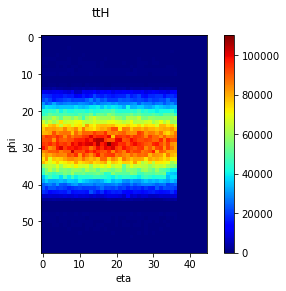

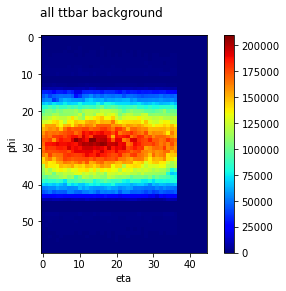

In [50]:
plt.imshow(grid_sg, cmap='jet')
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar()
plt.suptitle("ttH")
plt.show()

plt.imshow(grid_bg, cmap='jet')
plt.xlabel('eta')
plt.ylabel('phi')
plt.colorbar()
plt.suptitle("all ttbar background")
plt.show()

In [69]:
def get_index(val, cat, res=0.17):

    if cat == 'phi':
        val += np.pi
        # val = np.maximum()
        idx = np.minimum(val // res, 44).astype(int)
    if cat == 'eta':
        val += 5
        idx = np.minimum(val // res, 58).astype(int)
    return idx

jet_image = np.zeros((len(jet_data_arr), 45, 59), dtype=np.half)

for idx, event in enumerate(jet_data_arr):
    for i in range(14):
        eta = get_index(event[i,0], 'eta')
        phi = get_index(event[i, 1], 'phi')
        jet_image[idx, phi, eta] = event[i,2]



In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(jet_image, labels, stratify=labels, random_state=42, test_size=0.2)

In [77]:
y_train.shape

(306729,)

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from tensorflow.keras.models import Sequential, Model

inp = Input(shape=list(X_train.shape[1:])+[1])
conv1 = Conv2D(100, (2,2), strides=4, activation='relu', padding="SAME")(inp)
mp1 = MaxPooling2D(pool_size=2)(conv1)
flat = Flatten()(mp1)
out = Dense(1, activation="sigmoid")(flat)
model = Model(inputs=inp, outputs=out)
model.compile(loss="binary_crossentropy", optimizer="Nadam")

In [91]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

In [94]:
class_weights = {i:j for i,j in enumerate(class_weights)}

In [95]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64, class_weight=class_weights)

Epoch 1/3
5113/5113 [==============================] - 12s 2ms/step - loss: 0.6791 - val_loss: 0.6771
Epoch 2/3
5113/5113 [==============================] - 10s 2ms/step - loss: 0.6786 - val_loss: 0.6875
Epoch 3/3
5113/5113 [==============================] - 11s 2ms/step - loss: 0.6784 - val_loss: 0.6747


In [96]:
preds = model.predict(X_test)
preds.reshape(preds.shape[0])

array([0.41952497, 0.5403764 , 0.41952497, ..., 0.47297165, 0.41952497,
       0.4865431 ], dtype=float32)

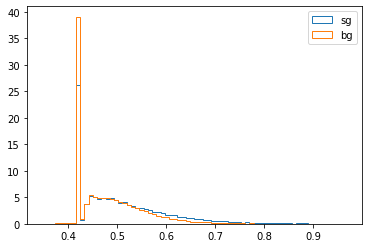

In [97]:
hist, bins, patches = plt.hist(preds[y_test==1], label='sg', histtype='step', bins='auto', density=True)
plt.hist(preds[y_test==0], label='bg', histtype='step', bins=bins, density=True)
plt.legend()
plt.show()
